# training histories for all models trained with searchnets stimuli

In [2]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pyprojroot import here
import seaborn as sns

import searchnets

#### helper functions

In [3]:
def get_net_number_from_dirname(dirname):
    return dirname.split('_')[-1]

In [4]:
def cm_to_inches(cm):
    return cm / 2.54

#### constants

In [5]:
CKPT_ROOT = here().joinpath('results/searchstims/checkpoints')
NET_EXPT_ROOTS = [path for path in sorted(CKPT_ROOT.iterdir()) if path.is_dir()]

In [9]:
NET_NAMES = [
    'CORnet_Z',
    'VGG16',
    'alexnet',
    'CORnet_S',
]

#### munge data

In [16]:
net_dfs = {}
for net_name in NET_NAMES:
    net_expt_roots = [path for path in NET_EXPT_ROOTS if net_name in str(path)]

    expt_dfs = {}
    for net_expt_root in net_expt_roots:

        # leave out control experiment from this figure
        if net_name == 'alexnet' and 'white_background' in str(net_expt_root):
            continue

        if 'detect' not in str(net_expt_root):
            continue

        expt_name = net_expt_root.name.replace(f'{net_name}_', '')  # will use as dict key

        dfs_this_expt = []
        net_roots = sorted(net_expt_root.joinpath('trained_200_epochs').glob('net_number*'))
        for net_root in net_roots:
            net_number = int(
                get_net_number_from_dirname(net_root.name)
            )

            events_csv = sorted(net_root.glob('**/*events*csv'))
            assert len(events_csv) == 1, 'found more than one events file'
            events_csv = events_csv[0]
            df = pd.read_csv(events_csv)
            df['replicate'] = net_number
            dfs_this_expt.append(df)
        expt_dfs[expt_name] = pd.concat(dfs_this_expt)
    net_dfs[net_name] = expt_dfs

#### make figures
first, figure in paper

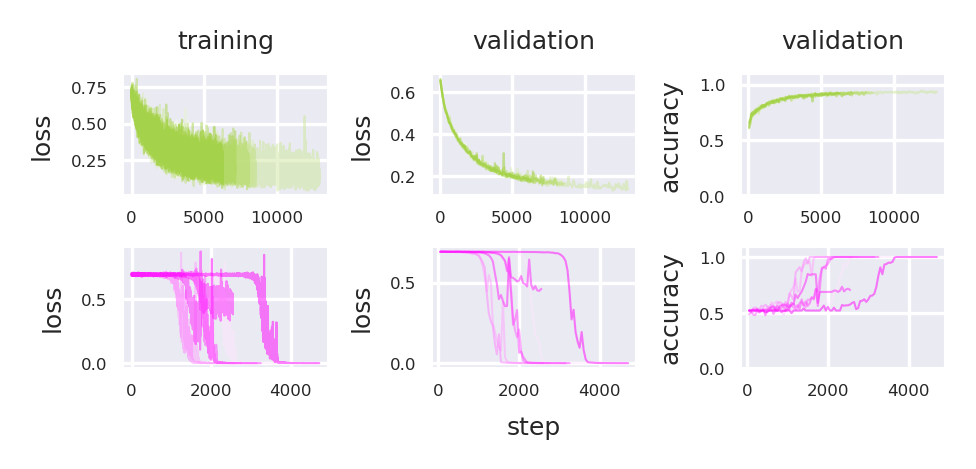

In [19]:
RC= {'axes.labelsize': 6,
     'axes.titlesize': 6,
     'xtick.labelsize': 4,
     'ytick.labelsize': 4,
     'legend.fontsize': 4,   
     }

sns.set_style("darkgrid")
sns.set_context("paper", rc=RC)

n_rows = 2
n_cols = 3  # train loss, val loss, val acc for transfer / initalize

DPI=300
FIGSIZE = tuple(cm_to_inches(size) for size in (8.4, 4.2))
fig, ax = plt.subplots(n_rows, n_cols, figsize=FIGSIZE, dpi=DPI)

ys = ['loss/train', 'loss/val', 'acc/val']
ylabels = ['loss', 'loss', 'accuracy']
col_labels = ['training', 'validation', 'validation']

for net_name in ['VGG16']:
    expt_dfs = net_dfs[net_name]
    for expt_name in expt_dfs.keys():
        expt_df = expt_dfs[expt_name]
        n_replicates = len(expt_df['replicate'].unique())
        if 'transfer' in expt_name:
            row = 0
            palette = sns.light_palette("yellowgreen", n_colors=n_replicates)
        elif 'initialize' in expt_name:
            row = 1
            palette = sns.light_palette("magenta", n_colors=n_replicates)
        
        for col, (y, ylabel, col_label) in enumerate(zip(ys, ylabels, col_labels)):
            sns.lineplot(x='step', y=y, hue='replicate', data=expt_df, 
                         ci=None, legend=False, alpha=0.5, ax=ax[row, col], palette=palette,
                         linewidth=0.5);
            ax[row, col].set_ylabel(ylabel)
            ax[row, col].set_xlabel('')
            if row == 0:
                ax[row, col].set_title(col_label)
            ax[row, col].tick_params(axis='both', which='both', length=0)  # turn off invisible ticks
                
        ax[row, 2].set_ylim([0., 1.1])

ax[1, 1].set_xlabel('step', fontsize=6)

fig.tight_layout(h_pad=0.5, w_pad=0.25)

for ext in ('svg', 'png'):
    fig_path = here().joinpath(
        f'docs/static/detectnet/fig2/fig2.{ext}'
    )
    plt.savefig(fig_path, bbox_inches='tight')

figure with all training histories

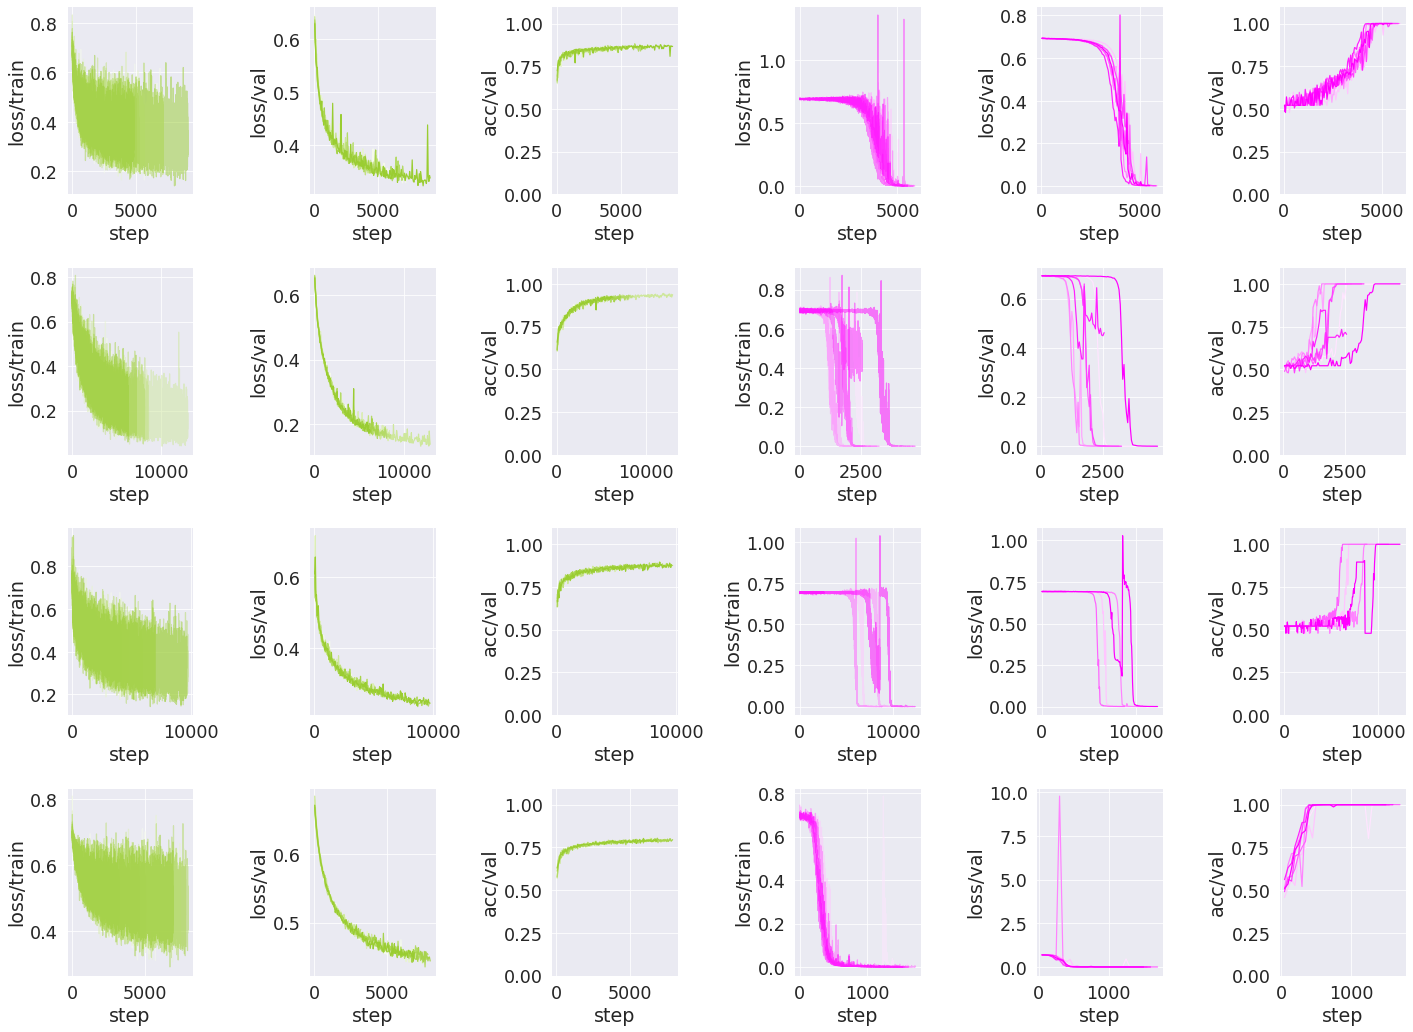

In [20]:
sns.set_context("paper", font_scale=2)

n_rows = len(NET_NAMES)
n_cols = 6  # train loss, val loss, val acc for transfer / initalize
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))

for row, net_name in enumerate(NET_NAMES):
    expt_dfs = net_dfs[net_name]
    for expt_name in expt_dfs.keys():
        expt_df = expt_dfs[expt_name]
        n_replicates = len(expt_df['replicate'].unique())
        if 'transfer' in expt_name:
            col_start_ind = 0
            palette = sns.light_palette("yellowgreen", n_colors=n_replicates)
        elif 'initialize' in expt_name:
            col_start_ind = 3
            palette = sns.light_palette("magenta", n_colors=n_replicates)
            
        sns.lineplot(x='step', y='loss/train', hue='replicate', data=expt_df, 
                     ci=None, legend=False, alpha=0.5, ax=ax[row, col_start_ind + 0], palette=palette);
        sns.lineplot(x='step', y='loss/val', hue='replicate', data=expt_df, 
                     ci=None, legend=False, ax=ax[row, col_start_ind + 1], palette=palette);
        sns.lineplot(x='step', y='acc/val', hue='replicate', data=expt_df, 
                     ci=None, legend=False, ax=ax[row, col_start_ind + 2], palette=palette);
        ax[row, col_start_ind + 2].set_ylim([0., 1.1])

#st = fig.suptitle(expt_name)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])